In [2]:
!pip install ultralytics -q

In [17]:
import os
import glob
import yaml
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from collections import Counter
import torch
from ultralytics import YOLO
import seaborn as sns
from collections import Counter, defaultdict
from IPython.display import Image, display

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

In [4]:
DATASET_DIR = '/kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo'
CLASS_NAMES = ['Glioma', 'Meningioma', 'Pituitary']
CLASS_COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
YAML_PATH = '/kaggle/working/braintumor_dataset.yaml'

print(f"Dataset Directory: {DATASET_DIR}")
print(f"Class Names: {CLASS_NAMES}")

Dataset Directory: /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo
Class Names: ['Glioma', 'Meningioma', 'Pituitary']


# Creating YAML

In [5]:
dataset_config = {
    'path': DATASET_DIR,
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(CLASS_NAMES),
    'names': CLASS_NAMES
}

with open(YAML_PATH, 'w') as f:
    yaml.dump(dataset_config, f, default_flow_style=False)

print("\nDataset Structure:")
for key, value in dataset_config.items():
    print(f"  - {key}: {value}")


Dataset Structure:
  - path: /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo
  - train: images/train
  - val: images/val
  - nc: 3
  - names: ['Glioma', 'Meningioma', 'Pituitary']


--> Mengkonfigurasi YAML untuk memberikan task ke model untuk fokus mencari dari ketiga taget class tersebut beserta informasi lokasi train dan validation set.

# EDA

In [6]:
def analyze_dataset(dataset_path, class_names):    
    stats = {
        'train': {'images': 0, 'labels': 0, 'classes': defaultdict(int)},
        'val': {'images': 0, 'labels': 0, 'classes': defaultdict(int)}
    }
    
    for split in ['train', 'val']:
        # Count images
        img_path = os.path.join(dataset_path, 'images', split)
        if os.path.exists(img_path):
            images = glob.glob(os.path.join(img_path, '*.jpg'))
            stats[split]['images'] = len(images)
        
        # Count labels and analyze classes
        label_path = os.path.join(dataset_path, 'labels', split)
        if os.path.exists(label_path):
            labels = glob.glob(os.path.join(label_path, '*.txt'))
            stats[split]['labels'] = len(labels)
            
            # Count instances per class
            for label_file in labels:
                with open(label_file, 'r') as f:
                    for line in f:
                        if line.strip():
                            class_id = int(line.strip().split()[0])
                            stats[split]['classes'][class_id] += 1
    
    return stats

In [7]:
dataset_stats = analyze_dataset(DATASET_DIR, CLASS_NAMES)

for split in ['train', 'val']:
    print(f"\n{split.upper()} SET:")
    print(f"- Images: {dataset_stats[split]['images']}")
    print(f"- Labels: {dataset_stats[split]['labels']}")
    print(f"- Background images (No Tumor): {dataset_stats[split]['images'] - dataset_stats[split]['labels']}")
    
    if dataset_stats[split]['classes']:
        print(f"  - Class distribution:")
        for class_id, count in dataset_stats[split]['classes'].items():
            if class_id < len(CLASS_NAMES):
                print(f"     {CLASS_NAMES[class_id]}: {count} instances")


TRAIN SET:
- Images: 4737
- Labels: 4026
- Background images (No Tumor): 711
  - Class distribution:
     Glioma: 1349 instances
     Pituitary: 1775 instances
     Meningioma: 1482 instances

VAL SET:
- Images: 512
- Labels: 411
- Background images (No Tumor): 101
  - Class distribution:
     Glioma: 153 instances
     Pituitary: 161 instances
     Meningioma: 142 instances


In [8]:
def plot_class_distribution(dataset_stats, class_names):
    classes = class_names.copy()
    train_counts = [dataset_stats['train']['classes'].get(i, 0) for i in range(len(classes))]
    val_counts = [dataset_stats['val']['classes'].get(i, 0) for i in range(len(classes))]
    
    # Add background images count
    classes.append('Background\n(No Tumor)')
    train_bg = dataset_stats['train']['images'] - dataset_stats['train']['labels']
    val_bg = dataset_stats['val']['images'] - dataset_stats['val']['labels']
    train_counts.append(train_bg)
    val_counts.append(val_bg)
    
    fig, ax = plt.subplots(figsize=(12, 7))
    
    x = np.arange(len(classes))
    width = 0.35
    
    bars1 = ax.bar(x - width/2, train_counts, width, label='Train', alpha=0.8, color='#2E8B57')
    bars2 = ax.bar(x + width/2, val_counts, width, label='Validation', alpha=0.8, color='#FF6347')
    ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Number of Instances', fontsize=12, fontweight='bold')
    ax.set_title('Brain Tumor Dataset - Class Instance Distribution', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(classes, fontsize=10)
    ax.legend(fontsize=11)
    ax.grid(axis='y', alpha=0.3)
    
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.annotate(f'{int(height)}',
                           xy=(bar.get_x() + bar.get_width() / 2, height),
                           xytext=(0, 3),
                           textcoords="offset points",
                           ha='center', va='bottom',
                           fontsize=9, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    total_train = sum(train_counts)
    total_val = sum(val_counts)
    print(f"\n📈 DATASET SUMMARY:")
    print(f"   Total Training samples: {total_train}")
    print(f"   Total Validation samples: {total_val}")
    print(f"   Total Dataset size: {total_train + total_val}")
    print(f"   Train/Val ratio: {total_train/(total_train+total_val):.1%} / {total_val/(total_train+total_val):.1%}")

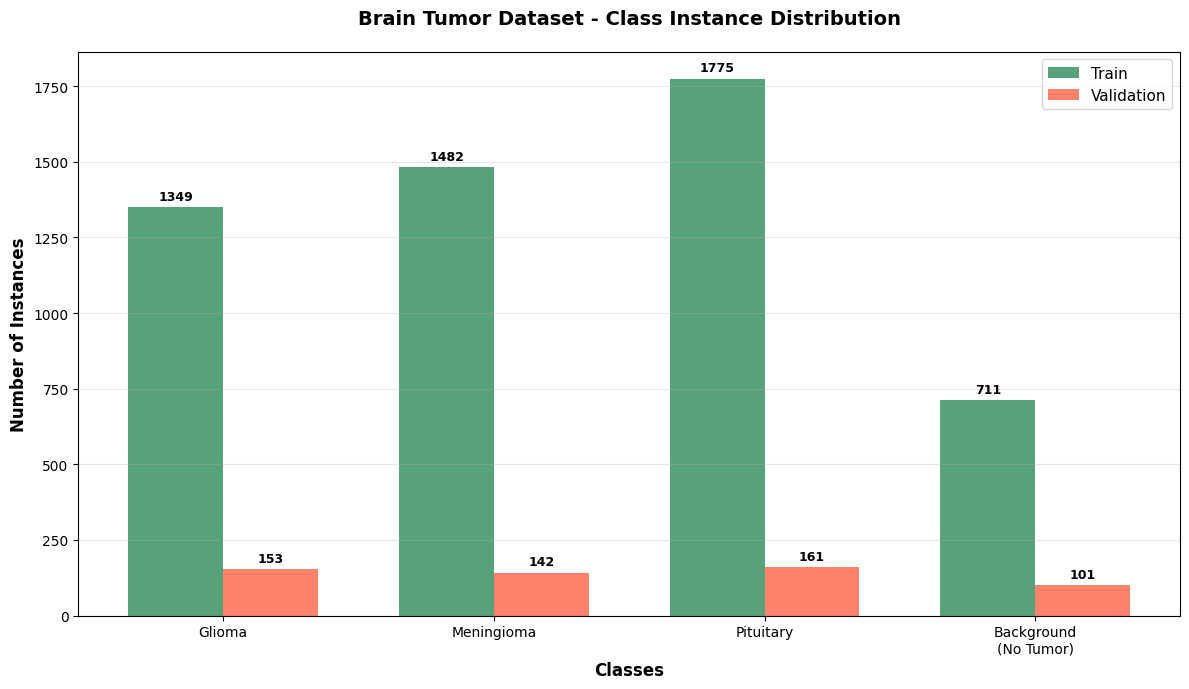


📈 DATASET SUMMARY:
   Total Training samples: 5317
   Total Validation samples: 557
   Total Dataset size: 5874
   Train/Val ratio: 90.5% / 9.5%


In [9]:
plot_class_distribution(dataset_stats, CLASS_NAMES)

In [10]:
def visualize_grid(image_dir, label_dir, num_images=16):
    all_image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    selected_files = random.sample(all_image_files, min(num_images, len(all_image_files)))
    
    grid_size = int(np.ceil(np.sqrt(len(selected_files))))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(15, 15))
    axs = axs.flatten()

    for i, img_file in enumerate(selected_files):
        img_path = os.path.join(image_dir, img_file)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape

        label_path = os.path.join(label_dir, img_file.replace('.jpg', '.txt'))
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width_norm, height_norm = map(float, parts[1:])
                    
                    box_w = width_norm * w
                    box_h = height_norm * h
                    x_min = int((x_center * w) - (box_w / 2))
                    y_min = int((y_center * h) - (box_h / 2))

                    # Draw rectangle
                    color = CLASS_COLORS[class_id]
                    cv2.rectangle(image, (x_min, y_min), (int(x_min + box_w), int(y_min + box_h)), color, 2)
                    
                    # Add class name
                    label = CLASS_NAMES[class_id]
                    cv2.putText(image, label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
        axs[i].imshow(image)
        axs[i].set_title(img_file[:15] + '...', fontsize=8)
        axs[i].axis('off')

    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
        
    plt.tight_layout()
    plt.show()

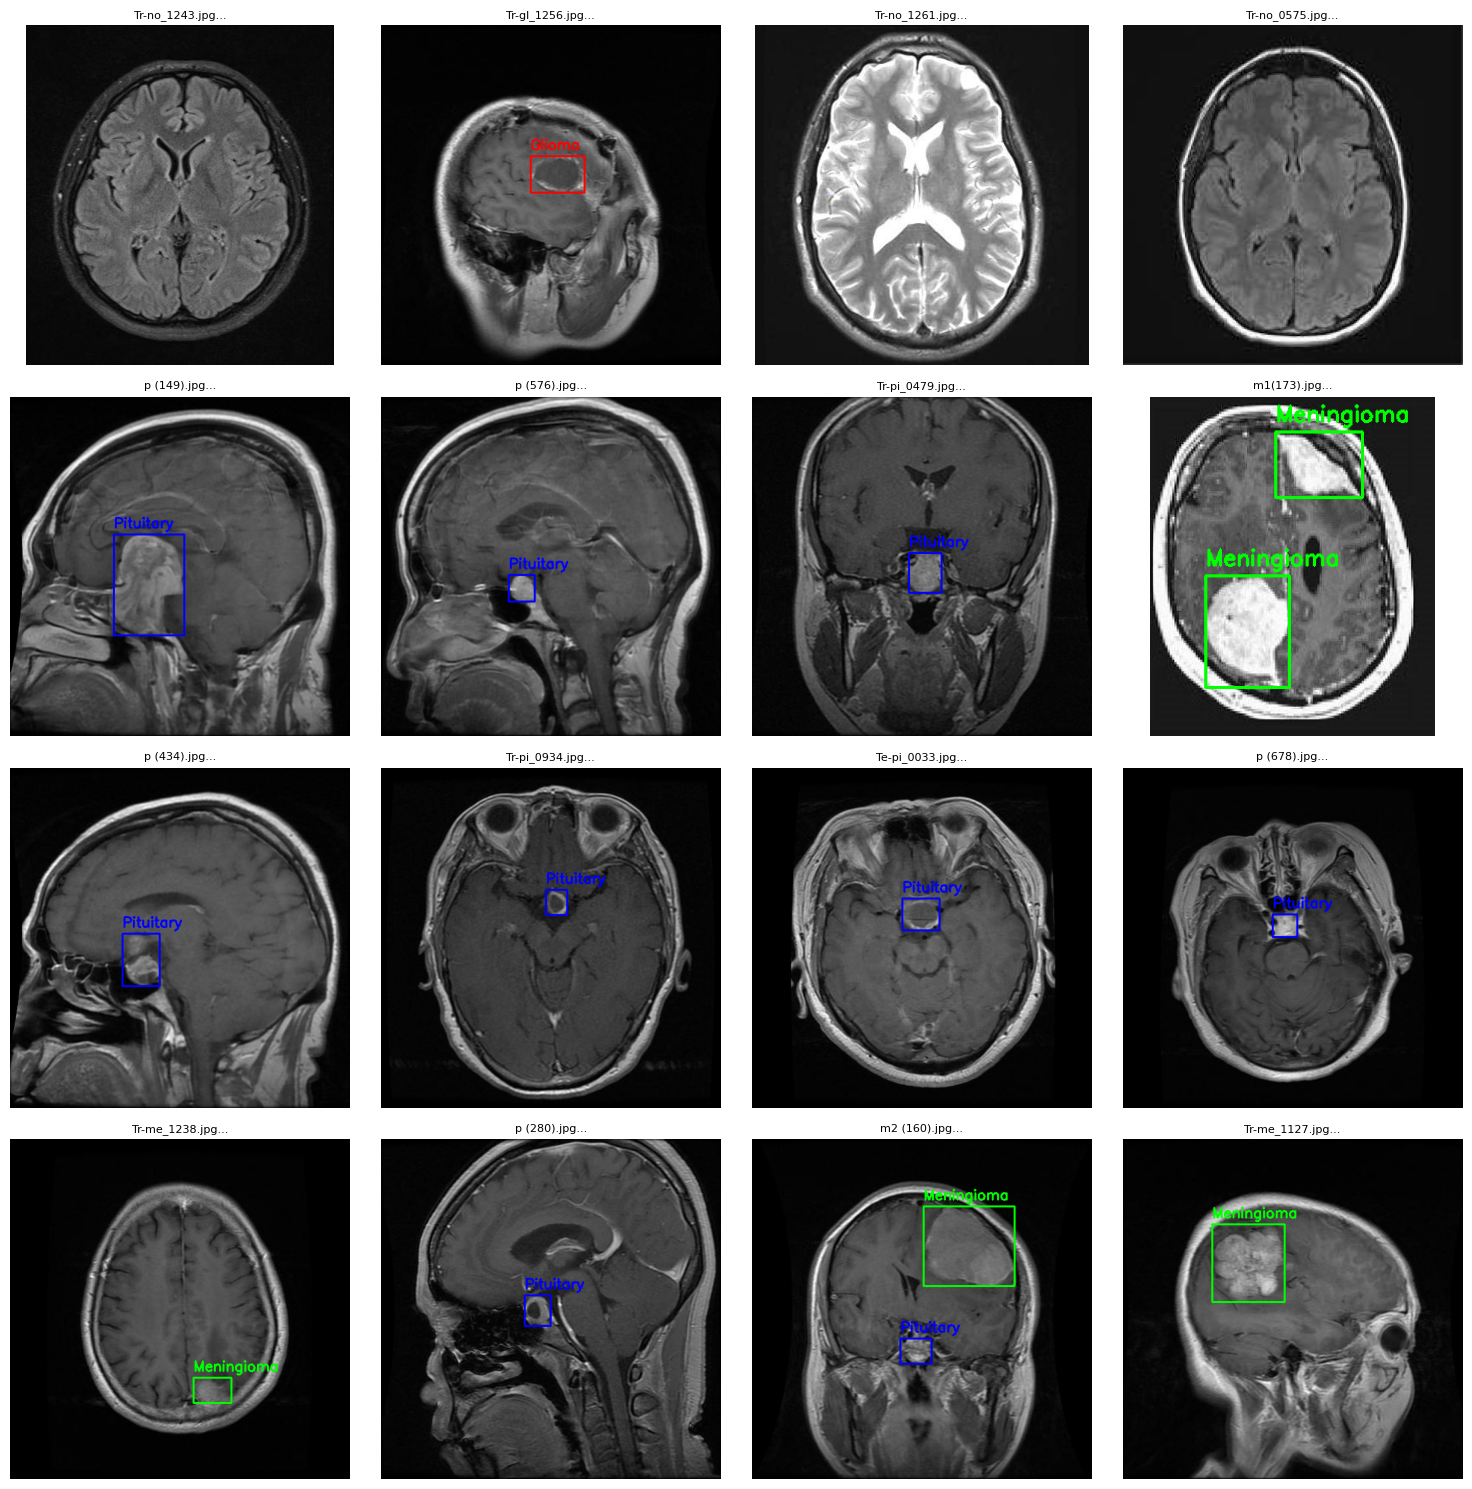

In [11]:
train_images_path = os.path.join(DATASET_DIR, 'images', 'train')
train_labels_path = os.path.join(DATASET_DIR, 'labels', 'train')
visualize_grid(train_images_path, train_labels_path)

# Model Training

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nUsing device: {device}")


Using device: cuda


In [13]:
model = YOLO('yolov8s.pt') 

results = model.train(
    data=YAML_PATH,
    epochs=50,
    imgsz=640,
    batch=8,
    patience=15,
    name='brain_tumor_yolov8n_run1',
    project='/kaggle/working/runs'
)

Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/braintumor_dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brain_tumor_yolov8n_run12, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=15, perspecti

train: Scanning /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels/train... 4026 images, 711 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:08<00:00, 530.94it/s]


WARNING ⚠️ train: Cache directory /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 8.4±3.7 MB/s, size: 28.4 KB)


val: Scanning /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels/val... 411 images, 101 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<00:00, 544.96it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels is not writeable, cache not saved.


Plotting labels to /kaggle/working/runs/brain_tumor_yolov8n_run12/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to /kaggle/working/runs/brain_tumor_yolov8n_run12
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.22G      1.128      1.829      1.204          1        640: 100%|██████████| 593/593 [01:49<00:00,  5.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.50it/s]

                   all        512        456      0.735      0.588      0.674      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.76G      1.153      1.209        1.2          3        640: 100%|██████████| 593/593 [01:45<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.80it/s]

                   all        512        456      0.776      0.729      0.769      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.78G      1.142      1.134      1.186          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]

                   all        512        456      0.763      0.747      0.829        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.83G      1.113      1.101      1.188          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.12it/s]

                   all        512        456      0.866       0.77      0.855      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.86G      1.092     0.9956      1.161          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]

                   all        512        456      0.835      0.815      0.879      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       2.9G      1.049     0.9053       1.15          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]

                   all        512        456      0.843      0.834      0.884      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.94G      1.041     0.8703      1.141          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]

                   all        512        456      0.858      0.826      0.886      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.97G      1.001     0.8245      1.117          3        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]

                   all        512        456      0.877      0.817      0.881      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.01G      1.019     0.8233      1.129          6        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.98it/s]

                   all        512        456      0.902      0.825      0.901      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.04G     0.9752     0.7967       1.11          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.84it/s]

                   all        512        456      0.925      0.847      0.926      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.07G     0.9846     0.7718      1.105          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.88it/s]

                   all        512        456      0.915       0.84      0.918      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.12G     0.9607     0.7532        1.1          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.67it/s]

                   all        512        456      0.925      0.871      0.934      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.15G     0.9498     0.7285      1.088          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.06it/s]

                   all        512        456      0.906      0.815      0.906        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.19G     0.9368     0.7226      1.084          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.92it/s]

                   all        512        456      0.913      0.877      0.935      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.23G     0.9386     0.6991      1.085          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]

                   all        512        456      0.889      0.869      0.923      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.26G     0.9291     0.6772      1.071          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.08it/s]


                   all        512        456      0.879      0.882       0.93      0.728

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50       3.3G     0.9271      0.677      1.075          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.09it/s]

                   all        512        456      0.934       0.86      0.945      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.34G     0.9074     0.6633      1.071          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.99it/s]

                   all        512        456      0.926       0.88      0.946      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.36G     0.9048     0.6561      1.066          3        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.96it/s]

                   all        512        456      0.906      0.889       0.94      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      3.41G     0.9101     0.6447      1.066          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]

                   all        512        456        0.9       0.88      0.936      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.45G     0.8824     0.6187      1.051          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.71it/s]

                   all        512        456      0.912      0.885      0.944      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.48G     0.8908      0.618      1.054          3        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.01it/s]

                   all        512        456      0.945      0.892      0.949      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.52G     0.8706     0.5984      1.049          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]

                   all        512        456      0.911      0.921      0.953      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.55G     0.8628     0.6013      1.043          1        640: 100%|██████████| 593/593 [01:45<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.85it/s]

                   all        512        456      0.913      0.876      0.936      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.59G     0.8456     0.5865      1.039          0        640: 100%|██████████| 593/593 [01:45<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.93it/s]

                   all        512        456      0.924      0.899      0.946      0.756



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.63G     0.8434     0.5758      1.032          0        640: 100%|██████████| 593/593 [01:45<00:00,  5.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]


                   all        512        456      0.936       0.91      0.954      0.747

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      3.65G     0.8424     0.5574      1.029          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.09it/s]


                   all        512        456      0.916      0.929      0.954      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50       3.7G      0.836      0.565      1.032          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]

                   all        512        456      0.929      0.907      0.953      0.758



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.85G     0.8312     0.5475      1.022          1        640: 100%|██████████| 593/593 [01:45<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  8.00it/s]

                   all        512        456       0.91      0.914      0.956      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.88G     0.8134      0.544      1.017          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.04it/s]

                   all        512        456      0.919      0.918       0.95      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      3.92G     0.8309      0.541      1.019          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.06it/s]


                   all        512        456      0.911      0.933       0.96      0.763

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      3.96G     0.8195     0.5361      1.017          3        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.75it/s]

                   all        512        456      0.925      0.914      0.956      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.11G     0.8066     0.5188       1.01          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


                   all        512        456      0.949       0.89      0.952      0.762

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.14G      0.789     0.5052      1.005          1        640: 100%|██████████| 593/593 [01:45<00:00,  5.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.10it/s]


                   all        512        456      0.947      0.903      0.955      0.772

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.16G     0.8046     0.4948      1.016          2        640: 100%|██████████| 593/593 [01:45<00:00,  5.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.97it/s]

                   all        512        456      0.914      0.922      0.946      0.765



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.21G     0.7965     0.5099      1.013          2        640: 100%|██████████| 593/593 [01:45<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]


                   all        512        456      0.922      0.933      0.951      0.774

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50       4.5G     0.7904     0.5031      1.002          2        640: 100%|██████████| 593/593 [01:45<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.14it/s]


                   all        512        456      0.935      0.911      0.958      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.54G     0.7801     0.4786      1.002          4        640: 100%|██████████| 593/593 [01:44<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.13it/s]


                   all        512        456      0.915      0.944      0.957      0.768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.57G     0.7739     0.4806      1.001          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.05it/s]

                   all        512        456      0.918      0.929      0.952       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.61G     0.7723     0.4687          1          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.11it/s]

                   all        512        456      0.918      0.934      0.952      0.776


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.64G     0.7053     0.4018     0.9658          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.12it/s]

                   all        512        456       0.93      0.925      0.958      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.68G      0.693     0.3858     0.9624          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.16it/s]


                   all        512        456      0.946       0.91      0.956      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50       4.7G     0.6863     0.3798     0.9535          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.17it/s]

                   all        512        456      0.923      0.926      0.957      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.75G     0.6797     0.3649     0.9513          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.21it/s]

                   all        512        456       0.95        0.9      0.955      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.79G     0.6644     0.3587     0.9406          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.25it/s]


                   all        512        456      0.927      0.923      0.957      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.94G     0.6646     0.3583     0.9433          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]


                   all        512        456      0.924      0.923      0.959      0.784

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.97G     0.6605     0.3496     0.9419          2        640: 100%|██████████| 593/593 [01:44<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.21it/s]

                   all        512        456      0.944      0.915      0.958      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      5.01G     0.6491     0.3427     0.9335          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.03it/s]


                   all        512        456      0.931      0.918      0.957       0.79

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      5.05G      0.646     0.3373     0.9326          0        640: 100%|██████████| 593/593 [01:44<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.02it/s]

                   all        512        456      0.948       0.91      0.961      0.788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      5.28G     0.6409     0.3363     0.9304          1        640: 100%|██████████| 593/593 [01:44<00:00,  5.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:03<00:00,  8.22it/s]

                   all        512        456      0.946      0.916      0.961      0.793



50 epochs completed in 1.520 hours.
Optimizer stripped from /kaggle/working/runs/brain_tumor_yolov8n_run12/weights/last.pt, 22.5MB
Optimizer stripped from /kaggle/working/runs/brain_tumor_yolov8n_run12/weights/best.pt, 22.5MB

Validating /kaggle/working/runs/brain_tumor_yolov8n_run12/weights/best.pt...
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,126,745 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  7.01it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        512        456      0.946      0.916      0.961      0.792
                Glioma        135        153      0.937      0.882      0.942      0.778
            Meningioma        140        142      0.986      0.996      0.994      0.849
             Pituitary        154        161      0.915       0.87      0.946      0.749
Speed: 0.2ms preprocess, 4.5ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to /kaggle/working/runs/brain_tumor_yolov8n_run12


--> Hasil dari mAP50-95 cukup akurat terutama terhadap 'Meningioma', karena terget kita adalah image medical, maka target utama kita adalah menghasilkan Recall semaksimal mungkin untuk menangkat suatu penyakit. Hasil dari Recallnya cukup akurat dengan angka 0.916, dengan 'Meningioma' mendekati 100% sedangkat 'Glioma' dan 'Pituitary' berada di 87-88%. Overall, hasilnya cukup bagus sebagai basemodel menggunakan model Yolov8-small (~11,2M).

# Model Evaluation

In [15]:
run_dir = results.save_dir
print(f"Results saved in: {run_dir}")

Results saved in: /kaggle/working/runs/brain_tumor_yolov8n_run12


## Confusion Matrix


Displaying Confusion Matrix:


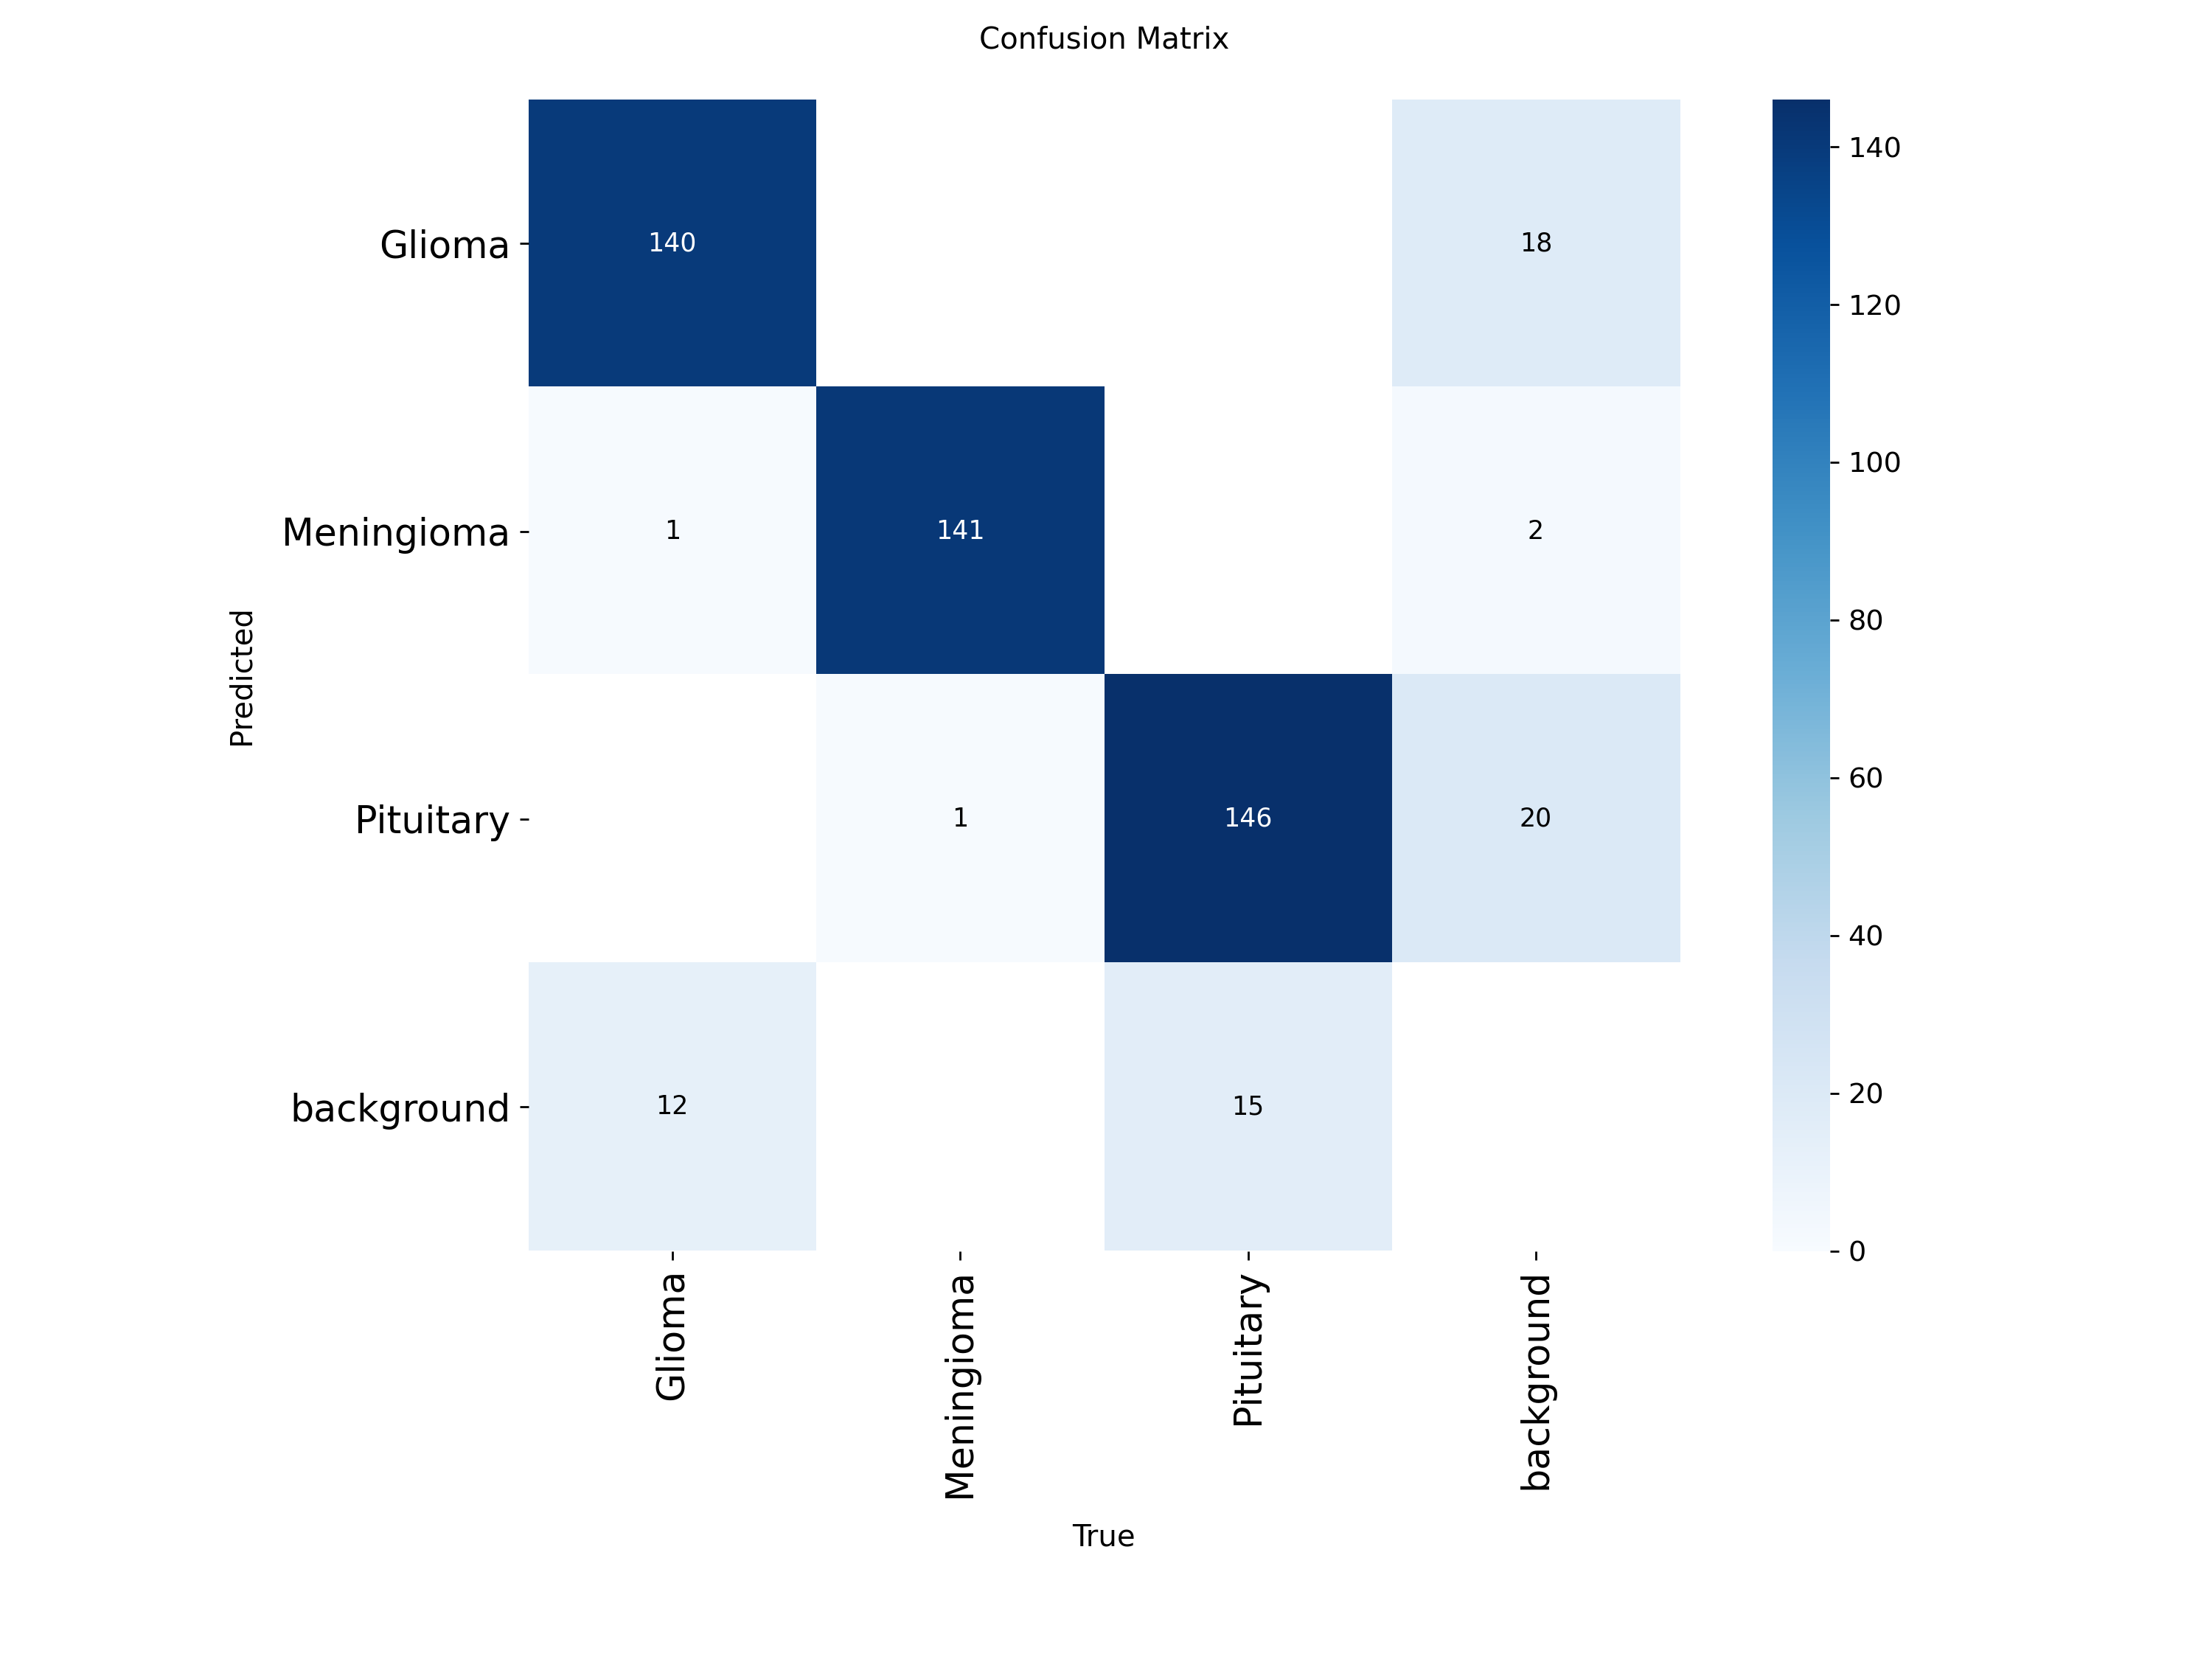


Displaying Performance Metrics:


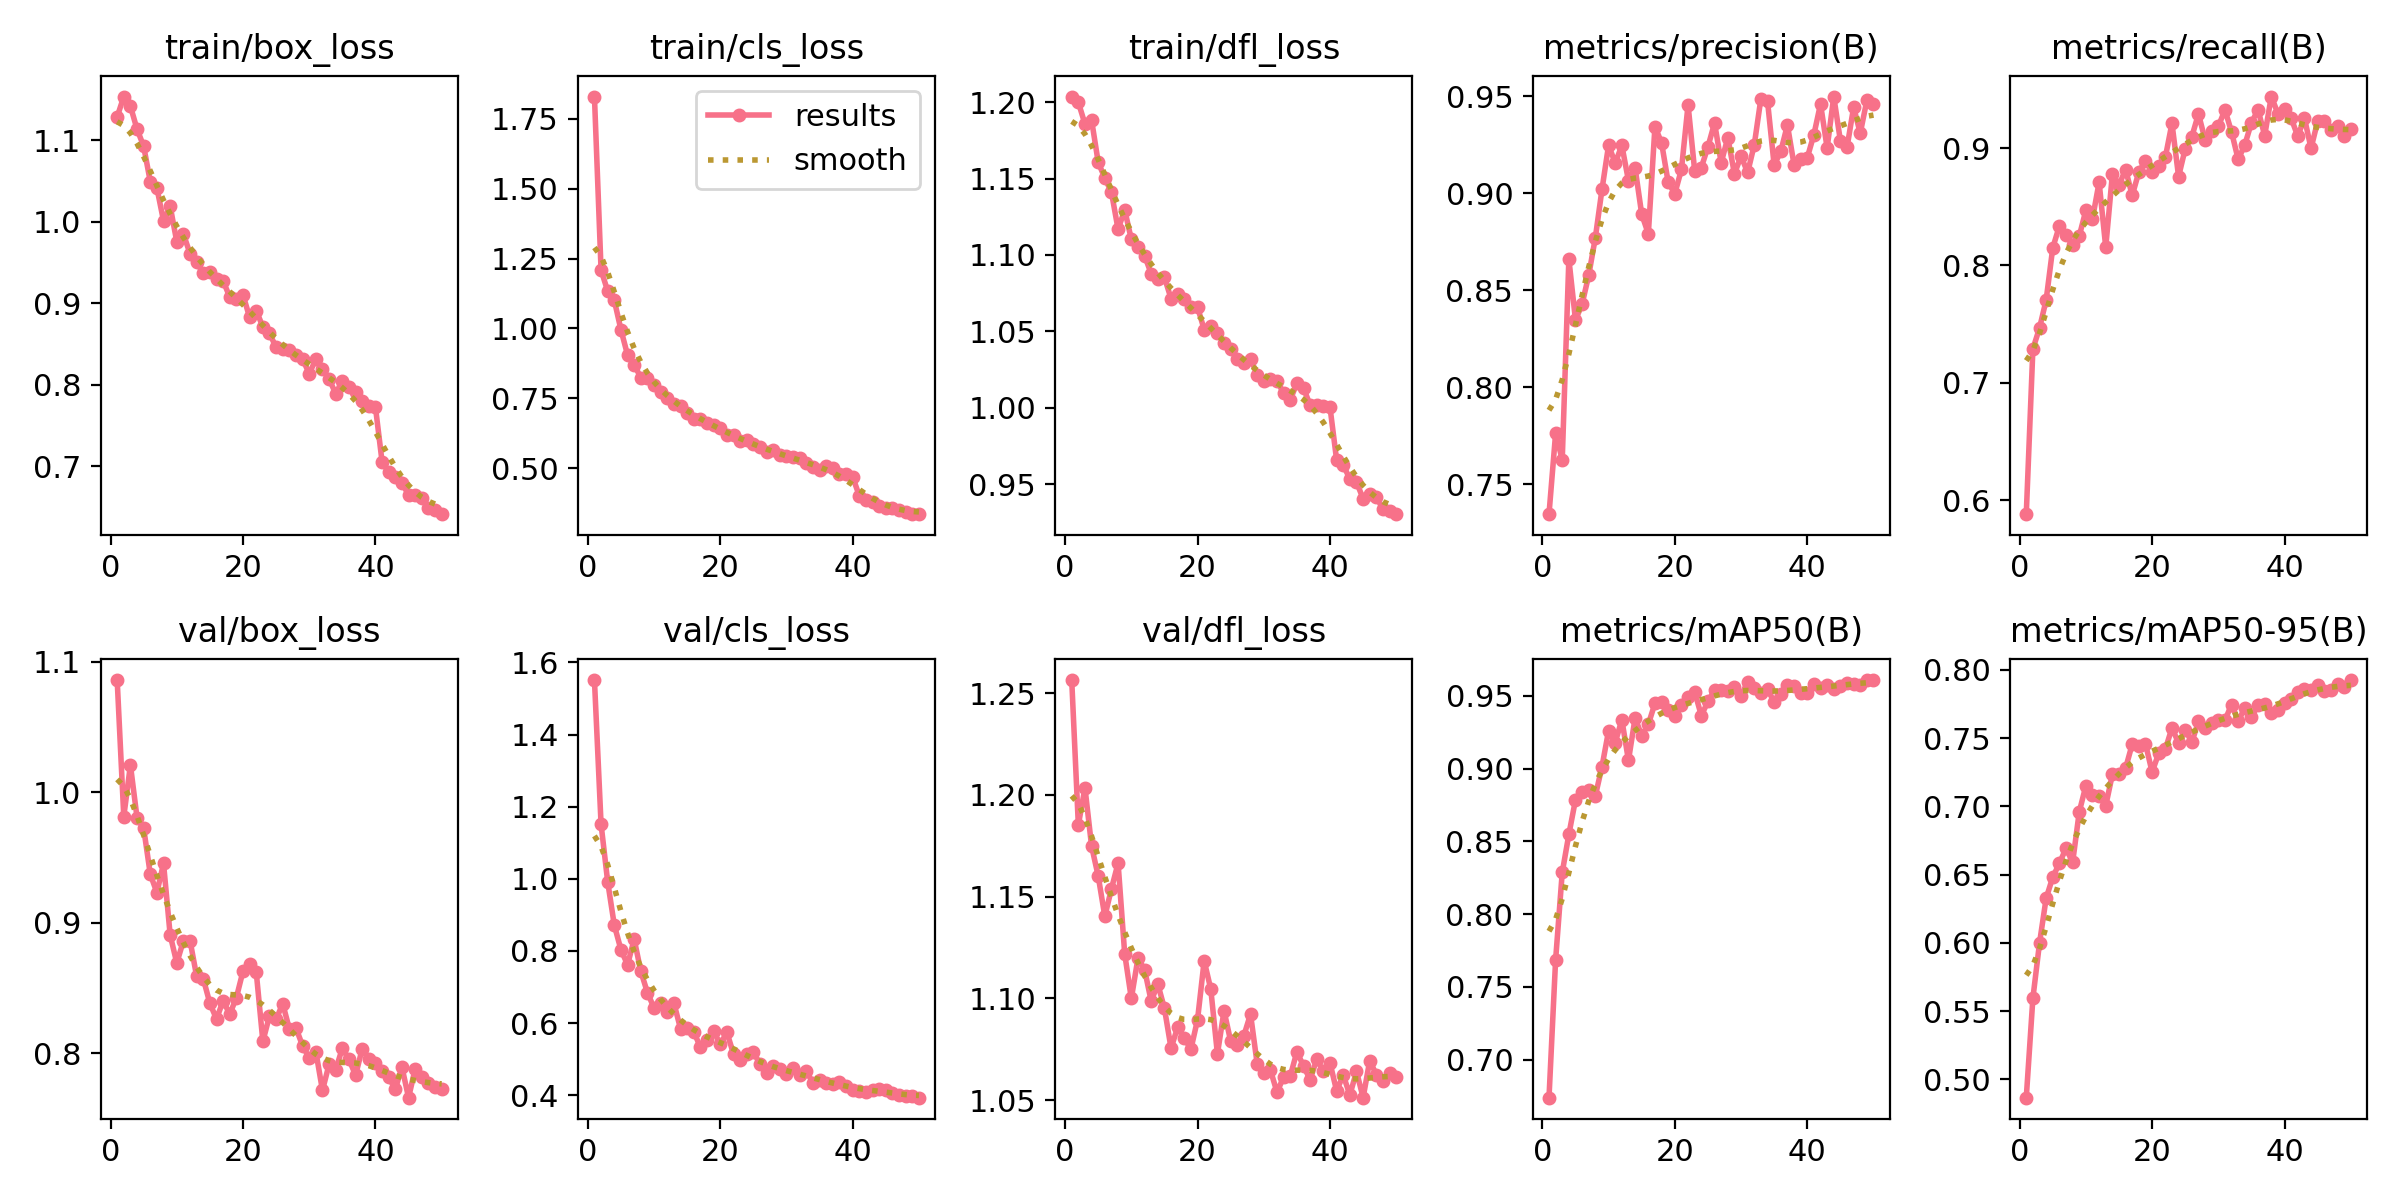

✅ Evaluation charts displayed!


In [19]:
print("\nDisplaying Confusion Matrix:")
confusion_matrix_path = os.path.join(run_dir, 'confusion_matrix.png')
display(Image(filename=confusion_matrix_path))


print("\nDisplaying Performance Metrics:")
results_chart_path = os.path.join(run_dir, 'results.png')
display(Image(filename=results_chart_path))

print("✅ Evaluation charts displayed!")

--> Grafik belum menunjukan hasil convergence ketika dirun selama 50 epoch, ini berarti masi banyak improvement yang bisa dilakukan untuk menghasilkan hasil maksimal. Untuk hasil sekarang cukup bagus, semua grafik selalu mencapai improvement baru, terutama mAP50-95.

In [20]:
best_model_path = os.path.join(run_dir, 'weights', 'best.pt')

# Load the trained model
best_model = YOLO(best_model_path)

## Image Prediction

In [21]:
val_images_path = os.path.join(DATASET_DIR, 'images', 'val')
random_val_images = random.sample(os.listdir(val_images_path), 5)

Predicting on random validation images...

0: 640x640 1 Meningioma, 9.4ms
1: 640x640 3 Meningiomas, 9.4ms
2: 640x640 1 Meningioma, 9.4ms
3: 640x640 1 Pituitary, 9.4ms
4: 640x640 1 Glioma, 9.4ms
Speed: 2.3ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict

Displaying prediction results:


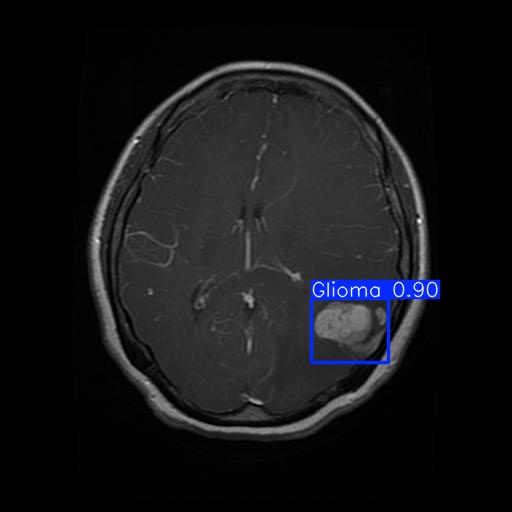

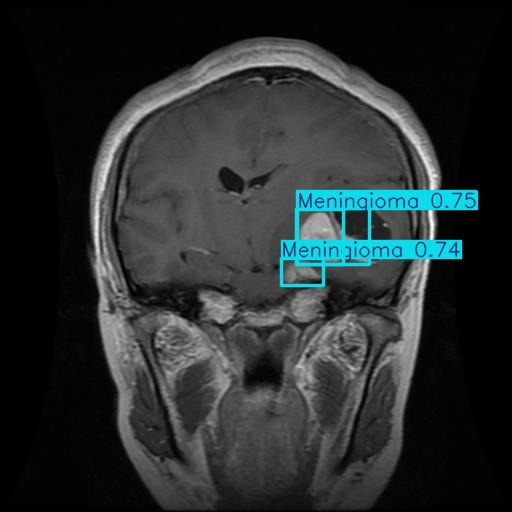

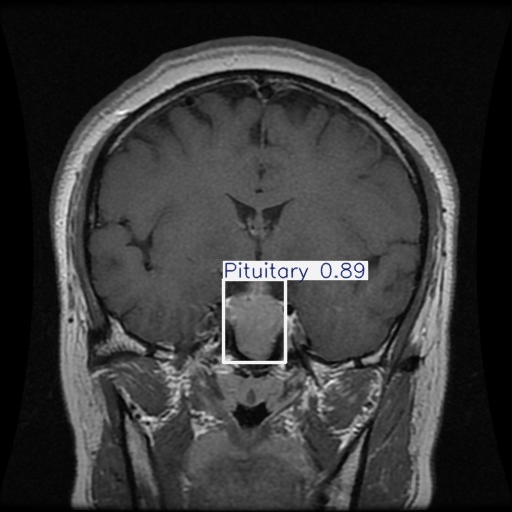

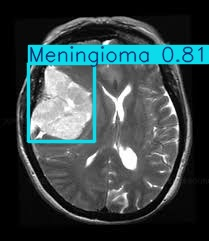

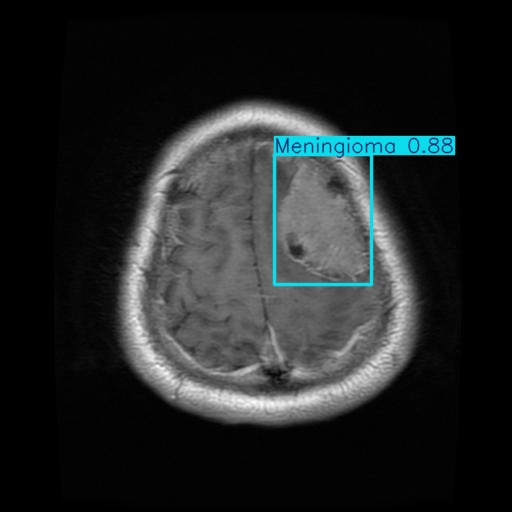

In [22]:
print("Predicting on random validation images...")
prediction_results = best_model.predict(source=[os.path.join(val_images_path, img) for img in random_val_images], save=True)

print("\nDisplaying prediction results:")
prediction_dir = prediction_results[0].save_dir

for img_file in os.listdir(prediction_dir):
    if img_file.endswith('.jpg'):
        display(Image(filename=os.path.join(prediction_dir, img_file)))

## Basic Eval

In [23]:
print("Evaluating on training set")
train_results = best_model.val(data=YAML_PATH, split='train')

print("Evaluating on validation set")
val_results = best_model.val(data=YAML_PATH, split='val')

Evaluating on training set
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 35.6±16.9 MB/s, size: 25.6 KB)


val: Scanning /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels/train... 4026 images, 711 backgrounds, 0 corrupt: 100%|██████████| 4737/4737 [00:06<00:00, 780.12it/s] 


WARNING ⚠️ val: Cache directory /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels is not writeable, cache not saved.


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 297/297 [00:37<00:00,  7.85it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       4737       4606      0.963      0.966       0.99      0.862
                Glioma       1152       1349      0.955       0.96       0.99      0.857
            Meningioma       1442       1482      0.989      0.994      0.994      0.897
             Pituitary       1671       1775      0.945      0.943      0.986      0.832
Speed: 0.2ms preprocess, 4.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val
Evaluating on validation set
Ultralytics 8.3.170 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 37.1±13.9 MB/s, size: 24.1 KB)


val: Scanning /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels/val... 411 images, 101 backgrounds, 0 corrupt: 100%|██████████| 512/512 [00:00<00:00, 752.39it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/brain-tumor-dataset-object-segmentation/brain_tumor_dataset_yolo/labels is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 32/32 [00:04<00:00,  6.43it/s]
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        512        456      0.946      0.916      0.961      0.791
                Glioma        135        153      0.937      0.882      0.942      0.778
            Meningioma        140        142      0.986      0.996      0.994      0.846
             Pituitary        154        161      0.915       0.87      0.946       0.75
Speed: 0.7ms preprocess, 4.8ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/val2


--> Hasil perbandingan antara training dan validation cukup baik, hasil ini menunjukan bahwa faktanya memang class 'Meningioma' merupakan class yang paling mudah dilakukan prediksi karena keunikannya struktur dan bentuknya. mAP50-95 dari training set tidak mencapai 90%, hal ini berarti masi ada banyak improvement yang bisa dilakukan untuk meningkatkan performa sehingga performa validation set juga dapat meningkat.

In [27]:
def display_metrics_comparison(train_res, val_res, class_names):
    print("\n" + "="*70)
    print("Train vs. Validation Metrics Comparison".center(70))
    print("="*70)
    print(f"{'Metric':<20} {'Train':<15} {'Validation':<15} {'Difference':<15}")
    print("-" * 70)
    
    # mAP metrics
    train_map50, val_map50 = train_res.box.map50, val_res.box.map50
    train_map, val_map = train_res.box.map, val_res.box.map
    print(f"{'mAP@0.5':<20} {train_map50:<15.3f} {val_map50:<15.3f} {abs(train_map50-val_map50):<15.3f}")
    print(f"{'mAP@0.5:0.95':<20} {train_map:<15.3f} {val_map:<15.3f} {abs(train_map-val_map):<15.3f}")
    
    # Precision and Recall
    train_precision, val_precision = train_res.box.mp, val_res.box.mp
    train_recall, val_recall = train_res.box.mr, val_res.box.mr
    print(f"{'Precision':<20} {train_precision:<15.3f} {val_precision:<15.3f} {abs(train_precision-val_precision):<15.3f}")
    print(f"{'Recall':<20} {train_recall:<15.3f} {val_recall:<15.3f} {abs(train_recall-val_recall):<15.3f}")
    
    # Per-class metrics
    print(f"\nmAP 0.5-0.95 COMPARISON:")
    print(f"{'Class':<15} {'Train':<15} {'Validation':<15} {'Difference':<15}")
    print("-" * 65)
    for i, name in enumerate(class_names):
        train_class_map = train_res.box.maps[i]
        val_class_map = val_res.box.maps[i]
        print(f"{name:<15} {train_class_map:<15.3f} {val_class_map:<15.3f} {abs(train_class_map-val_class_map):<15.3f}")

display_metrics_comparison(train_results, val_results, CLASS_NAMES)


               Train vs. Validation Metrics Comparison                
Metric               Train           Validation      Difference     
----------------------------------------------------------------------
mAP@0.5              0.990           0.961           0.029          
mAP@0.5:0.95         0.862           0.791           0.071          
Precision            0.963           0.946           0.017          
Recall               0.966           0.916           0.050          

mAP 0.5-0.95 COMPARISON:
Class           Train           Validation      Difference     
-----------------------------------------------------------------
Glioma          0.857           0.778           0.079          
Meningioma      0.897           0.846           0.052          
Pituitary       0.832           0.750           0.082          


In [ ]:
import shutil

results_dir_to_zip = results.save_dir 
output_zip_filename = 'brain_tumor_detection_results'
shutil.make_archive(output_zip_filename, 'zip', results_dir_to_zip)